In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                 

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [4]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on F1-score optimization.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []

    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")
    
    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/cir-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/cir-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/cir-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 751 files belonging to 2 classes.
Found 159 files belonging to 2 classes.
Found 166 files belonging to 2 classes.


In [5]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# Define a function to build a model transforming first layer to take grayscale

In [6]:
def build_model(base_model, transfer_learning):
    """
    Constructs a neural network model based on a specified base model and a transfer learning option.

    This function initializes a new model by setting the base model's trainable parameter according to 
    the transfer_learning flag ('Y' for non-trainable and 'N' for trainable). It modifies the input 
    layer to accommodate grayscale images and expands the single channel to three channels using a 
    Conv2D layer. The function then applies the base model and adds additional top layers for classification. 
    It returns the newly created model, which is suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-existing model to use as the base.
    - transfer_learning (str): A flag ('Y' or 'N') indicating whether to freeze (non-trainable) or unfreeze 
      (trainable) the layers of the base model for transfer learning.

    Returns:
    - keras.Model: The constructed model ready for training.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the model
    x = base_model(x)

    # Add own top layers for classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

# VGG TRANSFER LEARNING

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

train_data_rgb = train_data.map(convert_to_rgb)
val_data_rgb = val_data.map(convert_to_rgb)
test_data_rgb = test_data.map(convert_to_rgb)

prep_train_data = train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_val_data = val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_test_data = test_data_rgb.map(lambda x, y: (preprocess_input(x), y))


def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply the conversion
prep_train_data = prep_train_data.map(convert_to_grayscale)
prep_val_data = prep_val_data.map(convert_to_grayscale)
prep_test_data = prep_test_data.map(convert_to_grayscale)

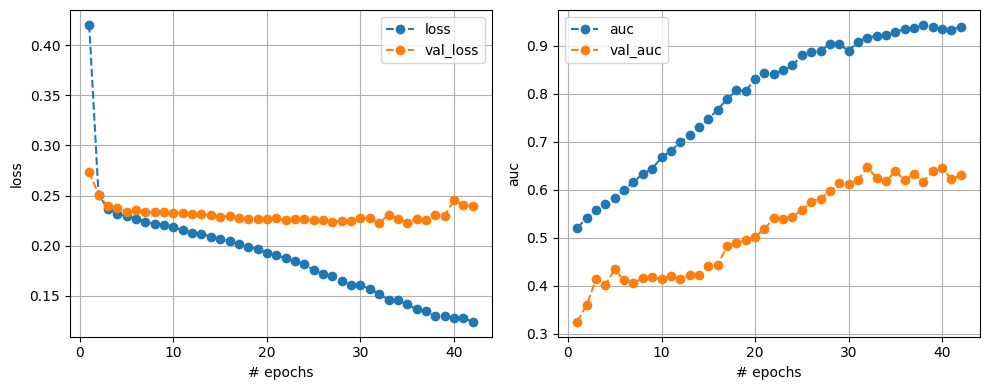

24/24 [==============================] - 10s 380ms/step - loss: 0.1240 - auc: 0.9398 - val_loss: 0.2397 - val_auc: 0.6304
Training time: 468.02260661125183 seconds


In [20]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='Y')
model_VGG16.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=METRICS)

# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(prep_train_data,
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.15 with F1-score: 0.31
  Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0   VGG16-TL  0.56                     0.31      0.89         0.33   

   Specificity   PPV   NPV   PLR   NLR  
0         0.94  0.29  0.95  5.13  0.71  


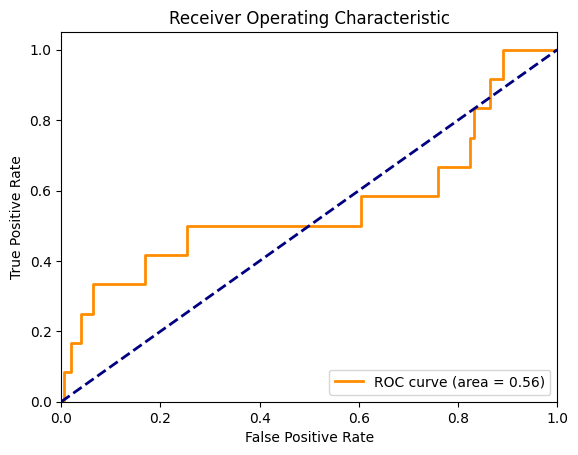

In [21]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-TL')

# Train on anterior placental images only

In [9]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-cir-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-cir-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-cir-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 384 files belonging to 2 classes.
Found 81 files belonging to 2 classes.
Found 87 files belonging to 2 classes.


In [10]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

train_data_rgb = train_data.map(convert_to_rgb)
val_data_rgb = val_data.map(convert_to_rgb)
test_data_rgb = test_data.map(convert_to_rgb)

prep_train_data = train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_val_data = val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_test_data = test_data_rgb.map(lambda x, y: (preprocess_input(x), y))


def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply the conversion to your datasets
prep_train_data = prep_train_data.map(convert_to_grayscale)
prep_val_data = prep_val_data.map(convert_to_grayscale)
prep_test_data = prep_test_data.map(convert_to_grayscale)

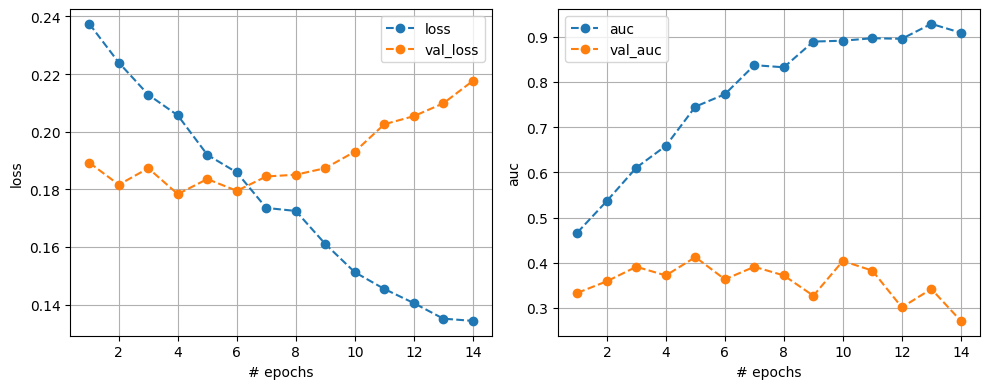

12/12 [==============================] - 6s 438ms/step - loss: 0.1343 - auc: 0.9086 - val_loss: 0.2176 - val_auc: 0.2714
Training time: 135.7110207080841 seconds


In [11]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='Y')
model_VGG16.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=METRICS)

# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(prep_train_data,
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.09 with F1-score: 0.40


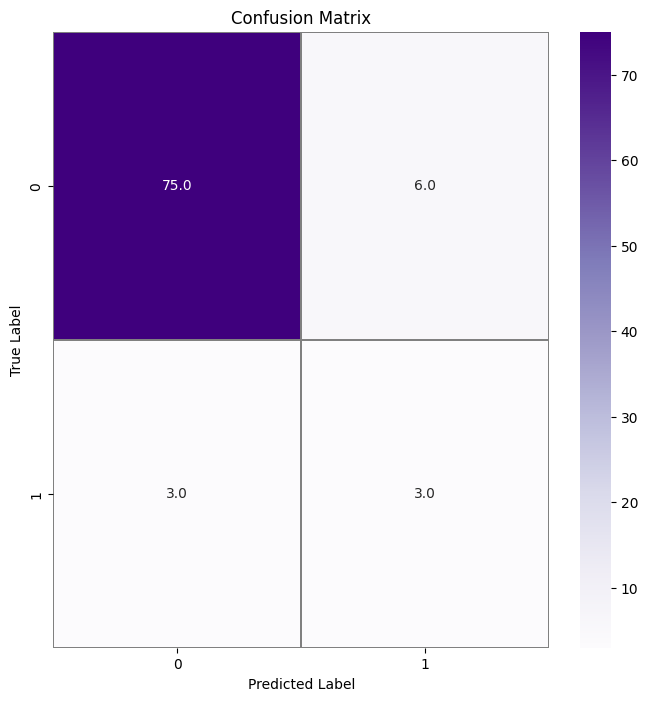

          Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-TL-anterior  0.74                      0.4       0.9          0.5   

   Specificity   PPV   NPV   PLR   NLR  
0         0.93  0.33  0.96  6.75  0.54  


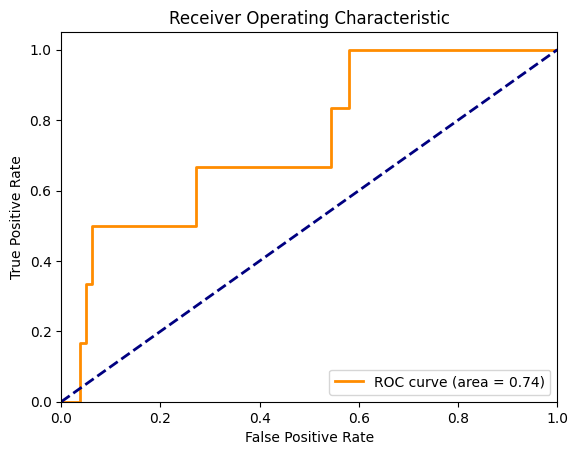

In [12]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-TL-anterior')

# Train on posterior placental images only

In [13]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-cir-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-cir-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-cir-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 365 files belonging to 2 classes.
Found 75 files belonging to 2 classes.
Found 84 files belonging to 2 classes.


In [14]:
train_data_rgb = train_data.map(convert_to_rgb)
val_data_rgb = val_data.map(convert_to_rgb)
test_data_rgb = test_data.map(convert_to_rgb)

prep_train_data = train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_val_data = val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_test_data = test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

prep_train_data = prep_train_data.map(convert_to_grayscale)
prep_val_data = prep_val_data.map(convert_to_grayscale)
prep_test_data = prep_test_data.map(convert_to_grayscale)

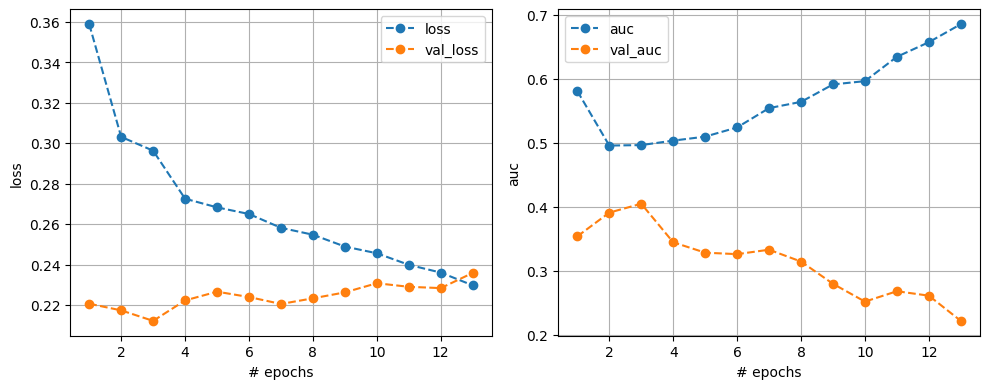

12/12 [==============================] - 5s 362ms/step - loss: 0.2298 - auc: 0.6854 - val_loss: 0.2359 - val_auc: 0.2222
Training time: 84.43516802787781 seconds


In [15]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='Y')
model_VGG16.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=METRICS)

# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(prep_train_data,
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.16 with F1-score: 0.40


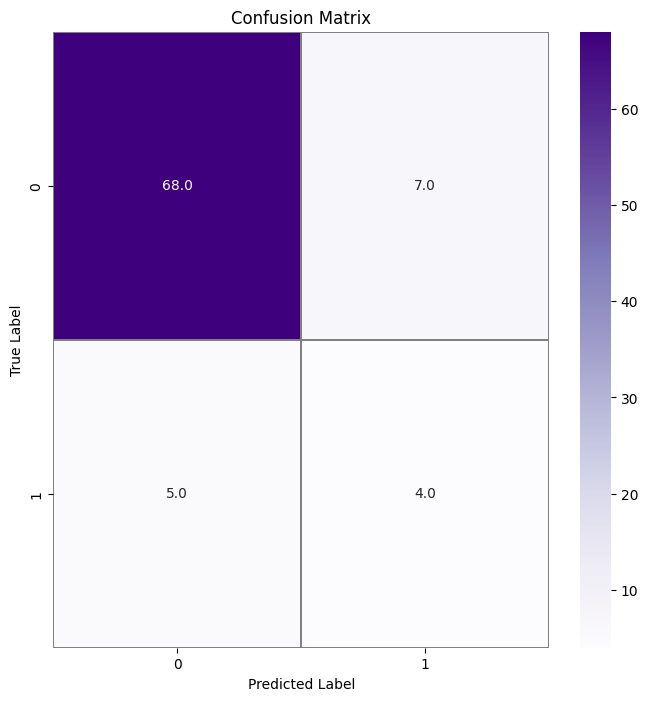

           Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-TL-posterior  0.79                      0.4      0.86         0.44   

   Specificity   PPV   NPV   PLR   NLR  
0         0.91  0.36  0.93  4.76  0.61  


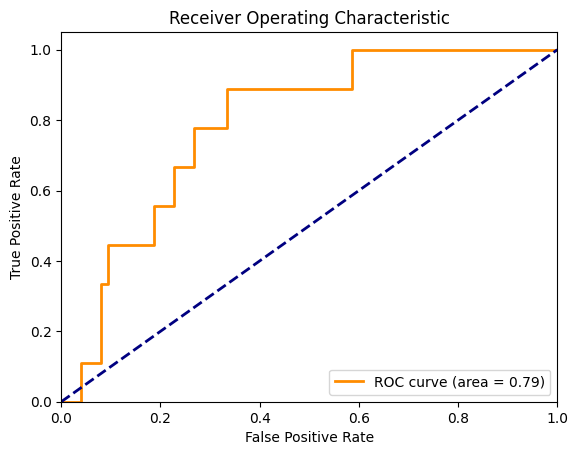

In [16]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-TL-posterior')

# Hyperparameter tuning of best model

Best model after re-training on different planes: posterior plane

In [17]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-cir-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-cir-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-cir-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 365 files belonging to 2 classes.
Found 75 files belonging to 2 classes.
Found 84 files belonging to 2 classes.


In [18]:
train_data_rgb = train_data.map(convert_to_rgb)
val_data_rgb = val_data.map(convert_to_rgb)
test_data_rgb = test_data.map(convert_to_rgb)

prep_train_data = train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_val_data = val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_test_data = test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

prep_train_data = prep_train_data.map(convert_to_grayscale)
prep_val_data = prep_val_data.map(convert_to_grayscale)
prep_test_data = prep_test_data.map(convert_to_grayscale)

In [29]:
import optuna

def build_model(base_model, transfer_learning, trial):
    if transfer_learning == 'Y':
        base_model.trainable = False
    else:
        base_model.trainable = True

    input_layer = Input(shape=(224, 224, 1), name='greyscale_input')
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)

    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        x = Dense(trial.suggest_int('units_l{}'.format(i), 50, 200), activation='relu')(x)
        dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=outputs)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=METRICS)

    return model

def objective(trial):
    base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='Y', trial=trial)

    vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    vgg_tl_checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)

    start = time.time()
    history = model_VGG16.fit(prep_train_data,
                              epochs=150,
                              validation_data=prep_val_data,
                              callbacks=[vgg_tl_callback, vgg_tl_checkpoint]
                             )
    end = time.time()
    print('Training time:', end - start, 'seconds')

    _, auc = model_VGG16.evaluate(prep_val_data, verbose=0)
    return auc

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-12-14 12:50:27,605] A new study created in memory with name: no-name-886e37a6-3866-4c32-8407-8e5b53dd3927


Epoch 1/150


/tmp/ipykernel_42/440797105.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/440797105.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


12/12 [==============================] - 7s 352ms/step - loss: 1.2609 - auc: 0.4742 - val_loss: 0.7915 - val_auc: 0.9005
Epoch 2/150
12/12 [==============================] - 5s 336ms/step - loss: 1.2362 - auc: 0.4673 - val_loss: 0.7365 - val_auc: 0.9051
Epoch 3/150
12/12 [==============================] - 5s 338ms/step - loss: 1.1680 - auc: 0.3837 - val_loss: 0.6853 - val_auc: 0.9120
Epoch 4/150
12/12 [==============================] - 6s 396ms/step - loss: 1.0497 - auc: 0.4351 - val_loss: 0.6399 - val_auc: 0.9120
Epoch 5/150
12/12 [==============================] - 5s 339ms/step - loss: 1.1303 - auc: 0.4472 - val_loss: 0.5955 - val_auc: 0.9213
Epoch 6/150
12/12 [==============================] - 5s 344ms/step - loss: 1.0981 - auc: 0.4364 - val_loss: 0.5553 - val_auc: 0.9236
Epoch 7/150
12/12 [==============================] - 6s 401ms/step - loss: 0.9522 - auc: 0.4612 - val_loss: 0.5187 - val_auc: 0.9282
Epoch 8/150
12/12 [==============================] - 5s 345ms/step - loss: 0.9289

[I 2023-12-14 12:59:45,536] Trial 0 finished with value: 0.9560185670852661 and parameters: {'n_layers': 1, 'units_l0': 156, 'dropout_l0': 0.33304277023220363, 'learning_rate': 3.36786374545231e-06}. Best is trial 0 with value: 0.9560185670852661.


Epoch 1/150
12/12 [==============================] - 7s 357ms/step - loss: 0.4780 - auc: 0.4634 - val_loss: 0.2398 - val_auc: 0.4097
Epoch 2/150
12/12 [==============================] - 5s 382ms/step - loss: 0.4494 - auc: 0.4861 - val_loss: 0.2546 - val_auc: 0.4259
Epoch 3/150
12/12 [==============================] - 5s 323ms/step - loss: 0.4393 - auc: 0.4428 - val_loss: 0.2549 - val_auc: 0.4514
Epoch 4/150
12/12 [==============================] - 5s 324ms/step - loss: 0.4266 - auc: 0.4993 - val_loss: 0.2445 - val_auc: 0.3750
Epoch 5/150
12/12 [==============================] - 5s 335ms/step - loss: 0.4589 - auc: 0.3991 - val_loss: 0.2363 - val_auc: 0.4167
Epoch 6/150
12/12 [==============================] - 5s 337ms/step - loss: 0.3973 - auc: 0.4837 - val_loss: 0.2302 - val_auc: 0.3981
Epoch 7/150
12/12 [==============================] - 5s 343ms/step - loss: 0.3994 - auc: 0.4914 - val_loss: 0.2259 - val_auc: 0.4005
Epoch 8/150
12/12 [==============================] - 5s 339ms/step - 

[I 2023-12-14 13:04:08,548] Trial 1 finished with value: 0.4236111342906952 and parameters: {'n_layers': 1, 'units_l0': 60, 'dropout_l0': 0.4314185038152087, 'learning_rate': 6.994954685306197e-05}. Best is trial 0 with value: 0.9560185670852661.


Epoch 1/150
12/12 [==============================] - 8s 359ms/step - loss: 0.8420 - auc: 0.5734 - val_loss: 0.5687 - val_auc: 0.5463
Epoch 2/150
12/12 [==============================] - 5s 331ms/step - loss: 0.8241 - auc: 0.5657 - val_loss: 0.5352 - val_auc: 0.5370
Epoch 3/150
12/12 [==============================] - 5s 339ms/step - loss: 0.8368 - auc: 0.4236 - val_loss: 0.5053 - val_auc: 0.5093
Epoch 4/150
12/12 [==============================] - 5s 343ms/step - loss: 0.7416 - auc: 0.5956 - val_loss: 0.4772 - val_auc: 0.5046
Epoch 5/150
12/12 [==============================] - 5s 337ms/step - loss: 0.7067 - auc: 0.5693 - val_loss: 0.4521 - val_auc: 0.4792
Epoch 6/150
12/12 [==============================] - 5s 345ms/step - loss: 0.6726 - auc: 0.5404 - val_loss: 0.4297 - val_auc: 0.4560
Epoch 7/150
12/12 [==============================] - 5s 341ms/step - loss: 0.6886 - auc: 0.5260 - val_loss: 0.4095 - val_auc: 0.4583
Epoch 8/150
12/12 [==============================] - 5s 339ms/step - 

[I 2023-12-14 13:15:42,283] Trial 2 finished with value: 0.4166666567325592 and parameters: {'n_layers': 3, 'units_l0': 155, 'dropout_l0': 0.44212147029141946, 'units_l1': 58, 'dropout_l1': 0.26030654447998003, 'units_l2': 165, 'dropout_l2': 0.3264584560085495, 'learning_rate': 7.65995978619389e-06}. Best is trial 0 with value: 0.9560185670852661.


Epoch 1/150
12/12 [==============================] - 7s 357ms/step - loss: 1.7679 - auc: 0.4835 - val_loss: 1.7890 - val_auc: 0.4838
Epoch 2/150
12/12 [==============================] - 5s 336ms/step - loss: 1.9015 - auc: 0.4724 - val_loss: 1.7239 - val_auc: 0.4815
Epoch 3/150
12/12 [==============================] - 5s 336ms/step - loss: 1.6101 - auc: 0.5825 - val_loss: 1.6604 - val_auc: 0.4861
Epoch 4/150
12/12 [==============================] - 5s 337ms/step - loss: 1.6781 - auc: 0.4672 - val_loss: 1.5999 - val_auc: 0.4838
Epoch 5/150
12/12 [==============================] - 5s 343ms/step - loss: 1.6898 - auc: 0.5053 - val_loss: 1.5396 - val_auc: 0.4769
Epoch 6/150
12/12 [==============================] - 5s 338ms/step - loss: 1.5818 - auc: 0.5378 - val_loss: 1.4812 - val_auc: 0.4722
Epoch 7/150
12/12 [==============================] - 5s 343ms/step - loss: 1.5066 - auc: 0.4421 - val_loss: 1.4253 - val_auc: 0.4699
Epoch 8/150
12/12 [==============================] - 6s 395ms/step - 

[I 2023-12-14 13:28:50,519] Trial 3 finished with value: 0.3472222685813904 and parameters: {'n_layers': 1, 'units_l0': 62, 'dropout_l0': 0.45679609170805907, 'learning_rate': 5.006936661180396e-06}. Best is trial 0 with value: 0.9560185670852661.


Epoch 1/150
12/12 [==============================] - 8s 356ms/step - loss: 0.4395 - auc: 0.5335 - val_loss: 0.2988 - val_auc: 0.5463
Epoch 2/150
12/12 [==============================] - 5s 343ms/step - loss: 0.4030 - auc: 0.5095 - val_loss: 0.2948 - val_auc: 0.5324
Epoch 3/150
12/12 [==============================] - 5s 339ms/step - loss: 0.4714 - auc: 0.3923 - val_loss: 0.2908 - val_auc: 0.5509
Epoch 4/150
12/12 [==============================] - 5s 347ms/step - loss: 0.3978 - auc: 0.5264 - val_loss: 0.2868 - val_auc: 0.5394
Epoch 5/150
12/12 [==============================] - 5s 340ms/step - loss: 0.3891 - auc: 0.4978 - val_loss: 0.2838 - val_auc: 0.5556
Epoch 6/150
12/12 [==============================] - 5s 343ms/step - loss: 0.3934 - auc: 0.5156 - val_loss: 0.2804 - val_auc: 0.5602
Epoch 7/150
12/12 [==============================] - 5s 339ms/step - loss: 0.3975 - auc: 0.5172 - val_loss: 0.2771 - val_auc: 0.5486
Epoch 8/150
12/12 [==============================] - 5s 345ms/step - 

[I 2023-12-14 13:42:18,909] Trial 4 finished with value: 0.7083333730697632 and parameters: {'n_layers': 3, 'units_l0': 129, 'dropout_l0': 0.47882777223745365, 'units_l1': 107, 'dropout_l1': 0.2473149333569455, 'units_l2': 129, 'dropout_l2': 0.2618322279788864, 'learning_rate': 2.3867158860267427e-06}. Best is trial 0 with value: 0.9560185670852661.


Epoch 1/150
12/12 [==============================] - 7s 361ms/step - loss: 2.1292 - auc: 0.5332 - val_loss: 1.7997 - val_auc: 0.7315
Epoch 2/150
12/12 [==============================] - 5s 337ms/step - loss: 2.0544 - auc: 0.4044 - val_loss: 1.7592 - val_auc: 0.7315
Epoch 3/150
12/12 [==============================] - 5s 341ms/step - loss: 1.9127 - auc: 0.6031 - val_loss: 1.7195 - val_auc: 0.7315
Epoch 4/150
12/12 [==============================] - 6s 396ms/step - loss: 1.9767 - auc: 0.5144 - val_loss: 1.6795 - val_auc: 0.7292
Epoch 5/150
12/12 [==============================] - 5s 339ms/step - loss: 1.8733 - auc: 0.5222 - val_loss: 1.6407 - val_auc: 0.7338
Epoch 6/150
12/12 [==============================] - 5s 346ms/step - loss: 2.0270 - auc: 0.4396 - val_loss: 1.6021 - val_auc: 0.7361
Epoch 7/150
12/12 [==============================] - 6s 397ms/step - loss: 1.9517 - auc: 0.5627 - val_loss: 1.5641 - val_auc: 0.7454
Epoch 8/150
12/12 [==============================] - 5s 343ms/step - 

[I 2023-12-14 13:55:46,404] Trial 5 finished with value: 0.7037037014961243 and parameters: {'n_layers': 1, 'units_l0': 155, 'dropout_l0': 0.489822738955611, 'learning_rate': 1.4909417718524586e-06}. Best is trial 0 with value: 0.9560185670852661.


Epoch 1/150
12/12 [==============================] - 8s 416ms/step - loss: 0.3627 - auc: 0.5458 - val_loss: 0.2434 - val_auc: 0.1574
Epoch 2/150
12/12 [==============================] - 6s 393ms/step - loss: 0.3467 - auc: 0.4995 - val_loss: 0.2317 - val_auc: 0.1644
Epoch 3/150
12/12 [==============================] - 5s 347ms/step - loss: 0.3116 - auc: 0.5360 - val_loss: 0.2237 - val_auc: 0.1806
Epoch 4/150
12/12 [==============================] - 5s 340ms/step - loss: 0.3105 - auc: 0.5565 - val_loss: 0.2188 - val_auc: 0.1898
Epoch 5/150
12/12 [==============================] - 6s 398ms/step - loss: 0.3246 - auc: 0.4272 - val_loss: 0.2153 - val_auc: 0.1991
Epoch 6/150
12/12 [==============================] - 5s 341ms/step - loss: 0.3135 - auc: 0.4813 - val_loss: 0.2134 - val_auc: 0.1991
Epoch 7/150
12/12 [==============================] - 5s 344ms/step - loss: 0.2880 - auc: 0.5782 - val_loss: 0.2117 - val_auc: 0.2060
Epoch 8/150
12/12 [==============================] - 5s 341ms/step - 

[I 2023-12-14 14:00:24,472] Trial 6 finished with value: 0.17824074625968933 and parameters: {'n_layers': 1, 'units_l0': 56, 'dropout_l0': 0.36214516964974874, 'learning_rate': 2.0130414382887272e-05}. Best is trial 0 with value: 0.9560185670852661.


Epoch 1/150
12/12 [==============================] - 8s 362ms/step - loss: 0.5323 - auc: 0.5395 - val_loss: 0.4303 - val_auc: 0.4468
Epoch 2/150
12/12 [==============================] - 5s 342ms/step - loss: 0.5134 - auc: 0.4416 - val_loss: 0.4103 - val_auc: 0.4468
Epoch 3/150
12/12 [==============================] - 5s 339ms/step - loss: 0.4816 - auc: 0.4615 - val_loss: 0.3925 - val_auc: 0.4421
Epoch 4/150
12/12 [==============================] - 5s 347ms/step - loss: 0.4641 - auc: 0.5001 - val_loss: 0.3769 - val_auc: 0.4421
Epoch 5/150
12/12 [==============================] - 6s 398ms/step - loss: 0.3962 - auc: 0.5431 - val_loss: 0.3619 - val_auc: 0.4468
Epoch 6/150
12/12 [==============================] - 5s 346ms/step - loss: 0.4586 - auc: 0.4913 - val_loss: 0.3480 - val_auc: 0.4468
Epoch 7/150
12/12 [==============================] - 5s 345ms/step - loss: 0.4094 - auc: 0.5836 - val_loss: 0.3353 - val_auc: 0.4421
Epoch 8/150
12/12 [==============================] - 5s 346ms/step - 

[I 2023-12-14 14:11:22,871] Trial 7 finished with value: 0.3819444477558136 and parameters: {'n_layers': 3, 'units_l0': 111, 'dropout_l0': 0.24342998169588467, 'units_l1': 106, 'dropout_l1': 0.29731021711769023, 'units_l2': 168, 'dropout_l2': 0.22326237143806227, 'learning_rate': 5.735605112309954e-06}. Best is trial 0 with value: 0.9560185670852661.


Epoch 1/150
12/12 [==============================] - 7s 361ms/step - loss: 0.6441 - auc: 0.4523 - val_loss: 0.4768 - val_auc: 0.7917
Epoch 2/150
12/12 [==============================] - 5s 344ms/step - loss: 0.5561 - auc: 0.4934 - val_loss: 0.4548 - val_auc: 0.7917
Epoch 3/150
12/12 [==============================] - 5s 341ms/step - loss: 0.5937 - auc: 0.4723 - val_loss: 0.4346 - val_auc: 0.7917
Epoch 4/150
12/12 [==============================] - 5s 343ms/step - loss: 0.5804 - auc: 0.4816 - val_loss: 0.4151 - val_auc: 0.7870
Epoch 5/150
12/12 [==============================] - 5s 341ms/step - loss: 0.5174 - auc: 0.6028 - val_loss: 0.3975 - val_auc: 0.7847
Epoch 6/150
12/12 [==============================] - 5s 345ms/step - loss: 0.4925 - auc: 0.5291 - val_loss: 0.3806 - val_auc: 0.7708
Epoch 7/150
12/12 [==============================] - 5s 343ms/step - loss: 0.4906 - auc: 0.5265 - val_loss: 0.3655 - val_auc: 0.7546
Epoch 8/150
12/12 [==============================] - 6s 397ms/step - 

[I 2023-12-14 14:25:09,925] Trial 8 finished with value: 0.6597222089767456 and parameters: {'n_layers': 1, 'units_l0': 83, 'dropout_l0': 0.47906149795658287, 'learning_rate': 8.783004802507923e-06}. Best is trial 0 with value: 0.9560185670852661.


Epoch 1/150
12/12 [==============================] - 8s 366ms/step - loss: 1.9388 - auc: 0.5124 - val_loss: 1.4295 - val_auc: 0.6389
Epoch 2/150
12/12 [==============================] - 6s 394ms/step - loss: 1.6516 - auc: 0.5844 - val_loss: 1.1061 - val_auc: 0.6042
Epoch 3/150
12/12 [==============================] - 6s 398ms/step - loss: 1.3682 - auc: 0.4522 - val_loss: 0.8548 - val_auc: 0.6088
Epoch 4/150
12/12 [==============================] - 5s 338ms/step - loss: 1.0709 - auc: 0.4662 - val_loss: 0.6664 - val_auc: 0.5625
Epoch 5/150
12/12 [==============================] - 5s 340ms/step - loss: 0.8023 - auc: 0.5543 - val_loss: 0.5324 - val_auc: 0.4907
Epoch 6/150
12/12 [==============================] - 5s 342ms/step - loss: 0.6842 - auc: 0.5995 - val_loss: 0.4356 - val_auc: 0.4097
Epoch 7/150
12/12 [==============================] - 5s 346ms/step - loss: 0.5988 - auc: 0.5379 - val_loss: 0.3665 - val_auc: 0.3704
Epoch 8/150
12/12 [==============================] - 6s 399ms/step - 

[I 2023-12-14 14:30:55,062] Trial 9 finished with value: 0.4745370149612427 and parameters: {'n_layers': 2, 'units_l0': 136, 'dropout_l0': 0.3850350635163719, 'units_l1': 125, 'dropout_l1': 0.3039984636140429, 'learning_rate': 3.2423203773182794e-05}. Best is trial 0 with value: 0.9560185670852661.


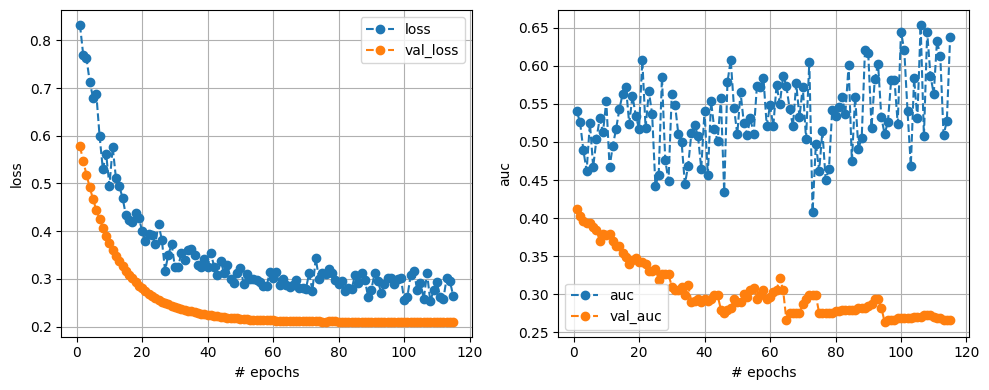

12/12 [==============================] - 5s 377ms/step - loss: 0.2638 - auc: 0.6372 - val_loss: 0.2100 - val_auc: 0.2662


In [31]:
# Extract the best hyperparameters
best_trial = study.best_trial.params

# Base model
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Rebuild the model with the best hyperparameters
model = build_model(base_model=base_model_VGG16, 
                    transfer_learning='Y', 
                    trial=optuna.trial.FixedTrial(best_trial))

# Callbacks
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

# Retrain the model
history = model.fit(prep_train_data,
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                   )

Best threshold: 0.05 with F1-score: 0.23


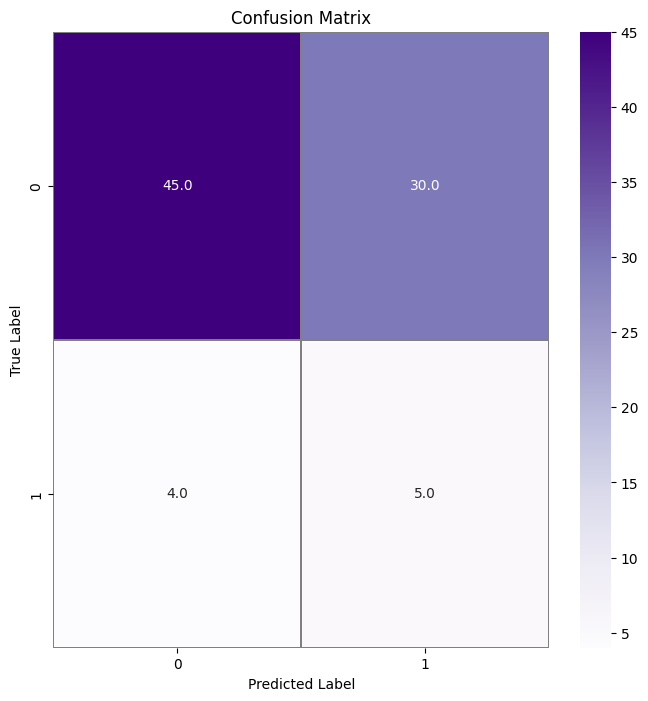

       Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-TL-tuned  0.55                     0.23       0.6         0.56   

   Specificity   PPV   NPV   PLR   NLR  
0          0.6  0.14  0.92  1.39  0.74  


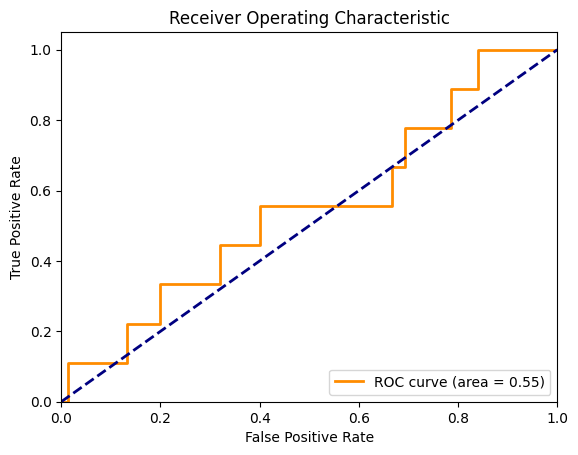

In [32]:
get_model_metrics(test_data=prep_test_data, model=model, model_name='VGG16-TL-tuned')